# linear model to classify the MNIST data set

## Prepare and get a sense of the data

We start by loading our image data set: MNIST. Using the function `load_digits` of the `datasets` module of `sklearn` provide the dataset in a reduced form suitable for this practival session.

Run the notebook in Google colab:
https://colab.research.google.com/github/heprom/cvml/blob/main/corrections/mnist_linear_classifier_cor.ipynb

In [213]:
# import numpy and initialize the random seed to yield consistent results
import numpy as np
np.random.seed(42)

In [214]:
from sklearn.datasets import load_digits
mnist = load_digits()

In [215]:
mnist.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

The data set need to be partitioned into train and test data. Here use the handy function `train_test_split` of `sklearn` to reserve 20% of the data to test your model.

/!\ The test data is to be left untouched.

In [247]:
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(mnist['data'], mnist['target'], test_size=0.2)
print('shape of train data is {}, type is {}'.format(X_train.shape, X_train.dtype))
print('shape of test data is {}, type is {}'.format(X_test.shape, X_test.dtype))

shape of train data is (1437, 64), type is float64
shape of test data is (360, 64), type is float64


observe the data points: they are in 64 bits floats but only integers values from 0 to 16. The data can therefore be safely casted to uint8 to reduce the memory footprint by a factor of 8.

In [217]:
print(X_train.min())
print(X_train.max())
print(np.unique(X_train))
X_train = X_train.astype(np.uint8)

0.0
16.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


plot an image using matplotlib. The function `imshow` can be used reshaping the data as $(8\times8)$ array.

Text(0.5, 1.0, 'image 0 in the train set')

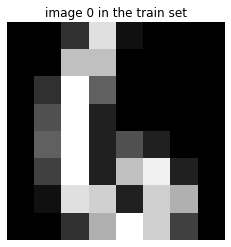

In [218]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt, cm

index = 0
plt.imshow(X_train[index].reshape((8, 8)), cmap=cm.gray)
plt.axis('off')
plt.title('image %d in the train set' % index)

With this particular dataset, the list of the categories is identical to their indices (from 0 to 9).

In [219]:
print('image {} is a {}'.format(index, y_train[index]))

image 0 is a 6


## Model definition

Here we define our simple machine learning algorithm which takes the features $x$, multiply them be some weights $W$ and add a bias term $b$.

$$f(x, W, b) = W.x + b = s$$

for a given image in vector form with $d$ features, W has size (10, d) so that the product $W.X$ produces 10 numbers which are called the scores for each class.

In [220]:
# initialization with random weights
W = 0.1 * np.random.randn(10, 64)
b = 0.1 * np.random.randn(10)

# apply the bias trick
W = np.c_[b, W]
print('shape of W is now {}'.format(W.shape))

shape of W is now (10, 65)


the data points are already in vector form, let's add 1 for the bias trick.

In [221]:
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
print('shape of train data is now {}'.format(X_train.shape))

X_test = np.c_[np.ones(X_test.shape[0]), X_test]
print('shape of test data is now {}'.format(X_test.shape))

shape of train data is now (1437, 65)
shape of test data is now (360, 65)


now compute the 10 scores for the `index` training image and use the max score to determine the prediction

In [222]:
scores = np.dot(W, X_train[index])
# look at the individual score for each class
for (label, score) in zip(labels, scores):
    print('{}: {:5.2f}'.format(label, score))

0: 10.47
1:  9.16
2: -3.46
3: -3.20
4: -4.26
5: -5.17
6: -2.96
7:  5.29
8:  2.92
9: -4.51


In [223]:
print('prediction: {}'.format(labels[np.argmax(scores)]))
print('ground thruth: {}'.format(labels[np.squeeze(y_train)[index]]))

prediction: 0
ground thruth: 6


## Loss function

### Hinge loss

We now need to define a way to tell the machine how happy we are with this prediction. The machine will then use this information to learn and come up with better predictions. The measure of our "happiness" is called a *loss function* and the process of learning the parameters (both $W$ and $b$) is called optimisation.

One possibility to measure how good is the prediction is the so called Hinge Loss:

$$L_i=\sum_{j\neq y_i}\max(0, s_j - s_{y_i} + 1)$$

Since it is inspired by linear support vector machines, this loss is also called Multi-class SVM Loss.

Now we can average arithmetically the losses $L_i$ for each instance $x_i$ to compute the general loss $L$ of the model.

$$L=\frac{1}{n}\sum_i L_i(f(x_i, W), y_i)$$

In [224]:
# step by step calculation of the loss
Li = 0
yi = np.squeeze(y_train)[index]  # ground truth target
for j in range(10):
    if j == yi:
        print('skipping %d' % j)
        continue
    margin = max(0, scores[j] - scores[yi] + 1)
    print('{:2d} {:6.2f} {:6.2f}'.format(j, scores[j], margin))
    Li += margin
print(18 * '-')
print('hinge loss is {:.1f}'.format(Li))

 0  10.47  14.43
 1   9.16  13.12
 2  -3.46   0.50
 3  -3.20   0.76
 4  -4.26   0.00
 5  -5.17   0.00
skipping 6
 7   5.29   9.24
 8   2.92   6.87
 9  -4.51   0.00
------------------
hinge loss is 44.9


now we understand how the hinge loss works, we can use a more efficient implementation and include it in a reusable function.

In [225]:
# inline calculation of the loss
yi = np.squeeze(y_train)[index]
Li = np.sum([max(0, scores[j] - scores[yi] + 1) for j in range(10) if j != yi])
print(Li)

# create a function to evaluate the loss for the given W for image index in the training set
def loss_i(W, index):
    yi = np.squeeze(y_train)[index]  # ground truth target
    scores = np.dot(W, X_train[index])
    Li = np.sum([max(0, scores[j] - scores[yi] + 1) for j in range(10) if j != yi])
    return Li

print(loss_i(W, index))

44.92905795787631
44.92905795787631


finally create a function to compute the average loss on a batch of images

In [226]:
def loss_batch(W, batch_size=100):
    L = 0.  # average loss
    for index in range(batch_size):
        L += loss_i(W, index)
    L /= batch_size
    return L

In [227]:
loss_batch(W, batch_size=50)

43.79448178192577

### Softmax loss

Another very popular loss function to use with multiclassification problems is the multinomial logistic or softmax loss (popular in deep learning). Here the score for each class is passed to the softmax function: exponentiated (and become positive) and normalized. This gives the probability distribution of this class:

$$P(Y=k|X=x_i)=\frac{e^{s_k}}{\sum_j e^{s_j}}$$

Now we have a probability we can try to maximize the likelihood which is equivalent to minimize the negative of the log likelihood:

$$L_i=-\log P(Y=k|X=x_i)=-\log\left(\frac{e^{s_k}}{\sum_j e^{s_j}}\right)$$

In [228]:
# start by exponentiating our scores to obtain unnormalized probabilities
escores = np.exp(scores)
norm_escores = escores / np.sum(escores)
for j in range(10):
    print('{:6d} | {:8.1f} | {:6.4f}'.format(j, escores[j], norm_escores[j]))
print(26 * '-')
# verify that the sum of the probability is 1
print('sum of probabilities check: {:.3f}'.format(np.sum(norm_escores)))
# compute the softmax loss
Li = -np.log(norm_escores[yi])
print('Softmax loss is {:.2f}'.format(Li))

     0 |  35410.2 | 0.7843
     1 |   9524.5 | 0.2109
     2 |      0.0 | 0.0000
     3 |      0.0 | 0.0000
     4 |      0.0 | 0.0000
     5 |      0.0 | 0.0000
     6 |      0.1 | 0.0000
     7 |    197.5 | 0.0044
     8 |     18.5 | 0.0004
     9 |      0.0 | 0.0000
--------------------------
sum of probabilities check: 1.000
Softmax loss is 13.68


## Learning the model

Here we use the calculated loss to optimize the parameters $W$ and $b$. For this we need to evaluate the gradient $\dfrac{\partial L}{\partial W}$ of $L$ with respect to $W$.

The gradient is obtained by differentiating the loss expression with respect to $W$:

$$\nabla_{w_j}L_i=1\left(w_j^T x_i - w_{y_i}^T x_i + 1 > 0\right) x_i\quad\text{for }j\neq y_i$$

$$\nabla_{w_{y_i}}L_i=-\left(\sum_{j\neq y_i}1\left(w_j^T x_i - w_{y_i}^T x_i + 1 > 0\right)\right) x_i$$

with $1(condition)$ equals to 1 if $condition$ is true, 0 otherwise. Here we see that the data vector $x$ is scaled by the number of classes that did not meet the margins.

In [229]:
# verify one more time the size of our matrices
print('shape of train data is {}'.format(X_train.shape))
print('shape of W is {}'.format(W.shape))

shape of train data is (1437, 65)
shape of W is (10, 65)


### Implementation

Simple SVM loss gradient implementation:
 - iterate over each data point $i$ in the batch
 - compute the score using $W.x_i$ (bias trick)
 - compute the margin for each class
 - compute the loss and the gradient components associated with this data point
 - finally average the gradient and the loss with respect to the number of data points in the batch

In [230]:
def svm_loss_gradient(W, X, y):
    """
    SVM loss gradient.

    Inputs:
    - W: array of shape (K, 1 + D) containing the weights.
    - X: array of shape (N, 1 + D) containing the data.
    - y: array of shape (N, 1) containing training labels 0 <= k < K.
    Returns a tuple of:
    - average loss
    - gradient of the loss with respect to weights W
    """
    dW = np.zeros_like(W)  # initialize the gradient as zero
    K = W.shape[0]  # number of classes
    n = X.shape[0]  # number of data points
    loss = 0.0
    for i in range(n):
        #print('evaluating gradient / image %d' % i)
        yi = np.squeeze(y)[i]  # ground truth target
        scores = np.dot(W, X[i])
        # compute SVM loss and gradient for this data point
        for j in range(K):
            if j == yi:
                continue
            # only compute loss if incorrectly classified
            margin = max(0, scores[j] - scores[yi] + 1)
            if margin > 0:
                loss += margin
                dW[yi, :] -= X[i]  # correct class gradient
                dW[j, :] += X[i]  # incorrect class gradient

    # average the loss and gradient
    loss /= n
    dW /= n
    return loss, dW

now try our SVM gradient loss by computing the gradient with respect to the first `nb` images in the training set.

In [231]:
nb = 100
loss, dW = svm_loss_gradient(W, X_train[:nb], y_train[:nb])
print('loss is {:.2f}'.format(loss))
print('gradient dW with respect to the first pixel =', dW[:, 2])

loss is 41.82
gradient dW with respect to the first pixel = [ 0.32  0.25 -0.29 -0.09  0.21 -1.13  0.14  0.29  0.13  0.17]


### Gradient check

now, to verify our SVM gradietn implementation, we are going to perform a **gradient check**. 

The gradient is computed numerically using a finite difference scheme:

$$\nabla L\approx\dfrac{L(W+h) - L(W-h)}{2h}$$

In [232]:
def gradient_check(f, W, h=0.0001):
    dL = np.zeros_like(W)
    # evaluate the loss modifiying each value of W
    for c in range(W.shape[0]):
        for p in range(W.shape[1]):
            W[c, p] += h
            fxph = f(W)
            W[c, p] -= 2*h
            fxmh = f(W)
            dL[c, p] = (fxph - fxmh) / (2 * h)  # centered finite differences
            W[c, p] += h  # put back initial value
    return dL

apply our gradient check, print the gradient with respect to the first pixel. Compare with the analytical value. Realize that to evaluate the gradient numerically, the loss function was called $2\times64$ times. This is why it is so slow. And we tested it only with 100 training images over 1437!

In [233]:
print('loss is {:.2f}'.format(loss_batch(W, batch_size=100)))
dL = gradient_check(loss_batch, W)
print(dL.shape)

loss is 41.82
(10, 65)


In [234]:
print(dL[:, 2])

[ 0.32  0.25 -0.29 -0.09  0.21 -1.13  0.14  0.29  0.13  0.17]


### Gradient Descent

now we have successfully created our linear model, loss function, and that we can compute the gradient of the loss with respect to $W$, let's actually use this to perform gradient descent and learn our model.

The backbone of the gradient descent is this simple equation:
$$W\leftarrow W - \eta \nabla_W L$$

$\eta$ is the learning rate (the most important hyperparameter). The weights $W$ are being updated at each iteration until a stop criterion is met or a maximum number of iteration reached.

In [244]:
# examine one single gradient descent step
W = 0.1 * np.random.randn(10, 65)
print('average loss is %.1f' % loss_batch(W, batch_size=X_train.shape[0]))
loss, dL_dw = svm_loss_gradient(W, X_train, y_train)

# perform one gradient descent
eta = 0.005
W = W - eta * dL_dw
print('after one step the average loss is %.1f' % loss_batch(W, batch_size=X_train.shape[0]))

average loss is 36.8
after one step the average loss is 16.3


### Batch gradient descent

because $n$ is large (1437 here), it does not actually make sense of computing the gradient on the complete set of training images at each iteration (remeber that the gradient is averaged). Instead, it is very common to compute the gradient on a subset (called a mini-batch) of 32 to 256 images. This is much faster and performs well.

In [236]:
W = np.random.randn(10, 65)  # initialization of the coefficients
eta = 0.005  # learning rate (< 1)
batch_size = 128
loss_history = []
it = 0
while it < 2000:
    # prepare batch
    idxs = np.random.choice(range(X_train.shape[0]), size=batch_size, replace=True)
    X_batch = X_train[idxs, :]
    y_batch = y_train[idxs]
    # evaluate loss and gradient
    loss, dL_dw = svm_loss_gradient(W, X_batch, y_batch)
    print('it {:d} - loss {:.1f}'.format(it, loss))
    # gradient descent
    W = W - eta * dL_dw
    W1.append(W[0, 11])
    W2.append(W[5, 35])
    loss_history.append(loss)
    it += 1

it 0 - loss 408.5
it 1 - loss 345.4
it 2 - loss 317.7
it 3 - loss 301.3
it 4 - loss 269.3
it 5 - loss 223.9
it 6 - loss 188.3
it 7 - loss 171.6
it 8 - loss 147.4
it 9 - loss 123.2
it 10 - loss 137.4
it 11 - loss 121.2
it 12 - loss 121.5
it 13 - loss 103.8
it 14 - loss 106.4
it 15 - loss 106.5
it 16 - loss 102.5
it 17 - loss 94.5
it 18 - loss 87.8
it 19 - loss 78.4
it 20 - loss 82.3
it 21 - loss 75.4
it 22 - loss 67.5
it 23 - loss 76.6
it 24 - loss 75.7
it 25 - loss 61.1
it 26 - loss 81.7
it 27 - loss 66.3
it 28 - loss 71.0
it 29 - loss 57.6
it 30 - loss 57.5
it 31 - loss 54.4
it 32 - loss 56.4
it 33 - loss 51.6
it 34 - loss 55.5
it 35 - loss 51.2
it 36 - loss 45.8
it 37 - loss 50.1
it 38 - loss 40.8
it 39 - loss 38.2
it 40 - loss 46.1
it 41 - loss 38.6
it 42 - loss 37.5
it 43 - loss 43.2
it 44 - loss 47.1
it 45 - loss 31.0
it 46 - loss 46.4
it 47 - loss 44.5
it 48 - loss 32.5
it 49 - loss 39.1
it 50 - loss 42.7
it 51 - loss 39.7
it 52 - loss 40.9
it 53 - loss 27.3
it 54 - loss 31.5
it 

it 516 - loss 3.1
it 517 - loss 3.1
it 518 - loss 4.0
it 519 - loss 3.5
it 520 - loss 2.9
it 521 - loss 3.0
it 522 - loss 3.2
it 523 - loss 2.8
it 524 - loss 2.3
it 525 - loss 2.9
it 526 - loss 2.0
it 527 - loss 1.7
it 528 - loss 2.8
it 529 - loss 4.1
it 530 - loss 1.7
it 531 - loss 4.4
it 532 - loss 2.2
it 533 - loss 3.2
it 534 - loss 2.6
it 535 - loss 2.8
it 536 - loss 4.7
it 537 - loss 0.6
it 538 - loss 5.3
it 539 - loss 2.3
it 540 - loss 3.1
it 541 - loss 2.7
it 542 - loss 3.9
it 543 - loss 3.3
it 544 - loss 3.0
it 545 - loss 4.8
it 546 - loss 4.4
it 547 - loss 4.3
it 548 - loss 1.9
it 549 - loss 6.0
it 550 - loss 3.2
it 551 - loss 1.6
it 552 - loss 3.5
it 553 - loss 2.6
it 554 - loss 2.4
it 555 - loss 3.2
it 556 - loss 4.2
it 557 - loss 3.0
it 558 - loss 4.1
it 559 - loss 3.0
it 560 - loss 3.0
it 561 - loss 2.5
it 562 - loss 4.2
it 563 - loss 4.1
it 564 - loss 2.7
it 565 - loss 3.4
it 566 - loss 5.5
it 567 - loss 0.9
it 568 - loss 3.3
it 569 - loss 2.4
it 570 - loss 1.3
it 571 - l

it 1027 - loss 3.4
it 1028 - loss 1.3
it 1029 - loss 1.6
it 1030 - loss 1.8
it 1031 - loss 0.7
it 1032 - loss 0.8
it 1033 - loss 1.5
it 1034 - loss 1.8
it 1035 - loss 1.9
it 1036 - loss 1.6
it 1037 - loss 2.7
it 1038 - loss 0.5
it 1039 - loss 1.1
it 1040 - loss 1.4
it 1041 - loss 2.0
it 1042 - loss 1.2
it 1043 - loss 2.8
it 1044 - loss 1.8
it 1045 - loss 3.8
it 1046 - loss 1.0
it 1047 - loss 1.4
it 1048 - loss 3.1
it 1049 - loss 1.6
it 1050 - loss 2.1
it 1051 - loss 1.7
it 1052 - loss 1.6
it 1053 - loss 2.2
it 1054 - loss 2.0
it 1055 - loss 0.9
it 1056 - loss 1.2
it 1057 - loss 2.5
it 1058 - loss 2.3
it 1059 - loss 1.7
it 1060 - loss 1.7
it 1061 - loss 1.0
it 1062 - loss 1.4
it 1063 - loss 1.8
it 1064 - loss 1.0
it 1065 - loss 1.7
it 1066 - loss 4.0
it 1067 - loss 1.2
it 1068 - loss 2.0
it 1069 - loss 0.8
it 1070 - loss 1.7
it 1071 - loss 1.3
it 1072 - loss 1.4
it 1073 - loss 1.7
it 1074 - loss 1.1
it 1075 - loss 2.7
it 1076 - loss 0.7
it 1077 - loss 1.4
it 1078 - loss 1.9
it 1079 - lo

it 1539 - loss 1.2
it 1540 - loss 0.8
it 1541 - loss 1.2
it 1542 - loss 1.6
it 1543 - loss 1.4
it 1544 - loss 0.8
it 1545 - loss 1.4
it 1546 - loss 0.9
it 1547 - loss 0.4
it 1548 - loss 1.1
it 1549 - loss 0.5
it 1550 - loss 1.1
it 1551 - loss 0.4
it 1552 - loss 1.5
it 1553 - loss 1.1
it 1554 - loss 0.4
it 1555 - loss 0.7
it 1556 - loss 2.1
it 1557 - loss 0.4
it 1558 - loss 1.1
it 1559 - loss 0.4
it 1560 - loss 1.0
it 1561 - loss 0.6
it 1562 - loss 1.0
it 1563 - loss 0.9
it 1564 - loss 1.4
it 1565 - loss 0.6
it 1566 - loss 0.6
it 1567 - loss 1.2
it 1568 - loss 1.8
it 1569 - loss 1.0
it 1570 - loss 1.1
it 1571 - loss 1.0
it 1572 - loss 1.2
it 1573 - loss 1.4
it 1574 - loss 1.5
it 1575 - loss 0.5
it 1576 - loss 1.1
it 1577 - loss 1.3
it 1578 - loss 1.0
it 1579 - loss 1.0
it 1580 - loss 0.8
it 1581 - loss 1.3
it 1582 - loss 0.3
it 1583 - loss 1.0
it 1584 - loss 1.8
it 1585 - loss 1.6
it 1586 - loss 0.8
it 1587 - loss 0.8
it 1588 - loss 0.9
it 1589 - loss 0.3
it 1590 - loss 0.1
it 1591 - lo

it 1979 - loss 0.7
it 1980 - loss 0.8
it 1981 - loss 1.4
it 1982 - loss 0.2
it 1983 - loss 0.4
it 1984 - loss 1.7
it 1985 - loss 0.4
it 1986 - loss 1.1
it 1987 - loss 1.0
it 1988 - loss 1.0
it 1989 - loss 1.4
it 1990 - loss 0.4
it 1991 - loss 1.4
it 1992 - loss 0.8
it 1993 - loss 1.5
it 1994 - loss 1.2
it 1995 - loss 1.2
it 1996 - loss 0.3
it 1997 - loss 0.9
it 1998 - loss 0.5
it 1999 - loss 1.4


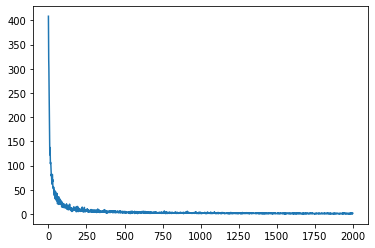

In [237]:
plt.plot(loss_history)

In [175]:
for i in range(20):
    y_pred = np.argmax(np.dot(W, X_test[i]))
    print('{} - {}'.format(y_pred, y_test[i]))

6 - 6
9 - 9
3 - 3
7 - 7
3 - 2
1 - 1
5 - 5
2 - 2
5 - 5
2 - 2
1 - 1
9 - 9
4 - 4
0 - 0
4 - 4
2 - 2
3 - 3
7 - 7
8 - 8
8 - 8


Construct the confusion matrix which is usefull to measure the performances of our multinomial classifier.

In [171]:
y_train_pred = np.argmax(np.dot(W, X_train.T), axis=0)
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_train, y_train_pred)

Text(0.5, 1.0, 'confusion matrix')

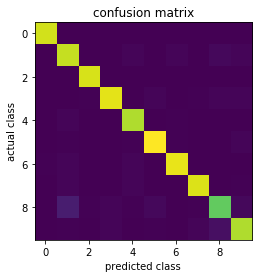

In [245]:
plt.imshow(conf)
plt.xlabel('predicted class')
plt.ylabel('actual class')
plt.title('confusion matrix')

To better visualize the errors, it is useful to normalize each row by the total number of samples in each category.

In [173]:
row_sums = conf.sum(axis=1, keepdims=True)
norm_conf = conf / row_sums

Text(0.5, 1.0, 'matrix of error rates')

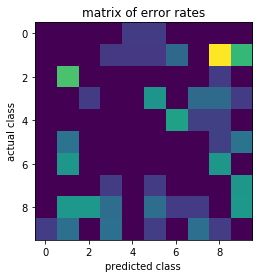

In [246]:
np.fill_diagonal(norm_conf, 0)
plt.imshow(norm_conf)
plt.xlabel('predicted class')
plt.ylabel('actual class')
plt.title('matrix of error rates')

The columns for classes 8 and 9 look worse than the other. Analyzing the type of errors of the model can help improving it.

Finally we can plot the optimized weights in (8x8) image form.

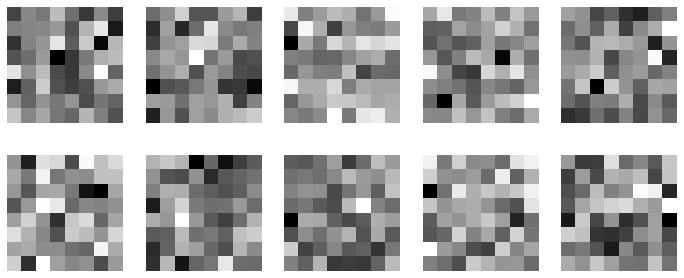

In [176]:
plt.figure(figsize=(12, 5))
plt.subplot(251); plt.imshow(W[0, 1:].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(252); plt.imshow(W[1, 1:].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(253); plt.imshow(W[2, 1:].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(254); plt.imshow(W[3, 1:].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(255); plt.imshow(W[4, 1:].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(256); plt.imshow(W[5, 1:].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(257); plt.imshow(W[6, 1:].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(258); plt.imshow(W[7, 1:].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(259); plt.imshow(W[8, 1:].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(2, 5, 10); plt.imshow(W[9, 1:].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.show()

## Compare our gradient descent results with sklearn

In [196]:
(X_train, X_test, y_train, y_test) = train_test_split(mnist['data'], mnist['target'], test_size=0.2)

In [197]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(random_state=42)
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [198]:
y_pred = clf.predict(X_test[:20])
for i in range(20):
    print('{} - {}'.format(y_pred[i], y_test[i]))

1 - 1
3 - 3
0 - 0
5 - 5
5 - 5
9 - 9
1 - 1
8 - 8
7 - 7
0 - 0
3 - 3
4 - 4
2 - 2
9 - 9
4 - 4
5 - 5
2 - 2
0 - 0
7 - 7
5 - 5


In [211]:
y_train_pred = clf.predict(X_train)
np.sum(y_train_pred == y_train) / X_train.shape[0]

0.9867780097425192

In [207]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.95867769, 0.95407098, 0.94092827])

In [204]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_train, y_train_pred)

Text(0.5, 1.0, 'confusion matrix')

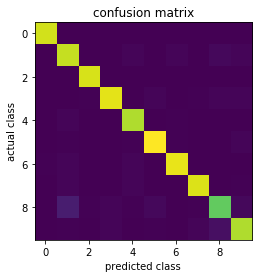

In [205]:
plt.imshow(conf)
plt.xlabel('predicted class')
plt.ylabel('actual class')
plt.title('confusion matrix')

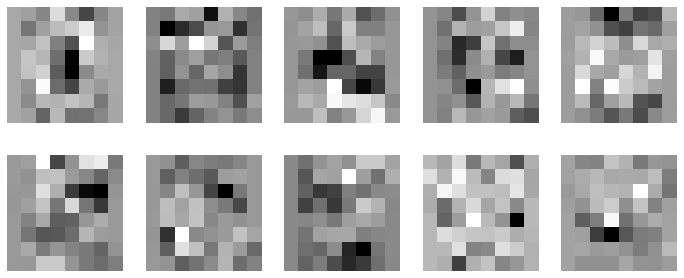

In [203]:
plt.figure(figsize=(12, 5))
plt.subplot(251); plt.imshow(clf.coef_[0].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(252); plt.imshow(clf.coef_[1].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(253); plt.imshow(clf.coef_[2].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(254); plt.imshow(clf.coef_[3].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(255); plt.imshow(clf.coef_[4].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(256); plt.imshow(clf.coef_[5].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(257); plt.imshow(clf.coef_[6].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(258); plt.imshow(clf.coef_[7].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(259); plt.imshow(clf.coef_[8].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.subplot(2, 5, 10); plt.imshow(clf.coef_[9].reshape((8, 8)), cmap=cm.gray); plt.axis('off')
plt.show()